In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import tensorflow as tf

In [446]:
import os

model_path = "/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_float32_8const/kfolding5/saved_model.pb"

# Check if the file exists
if os.path.exists(model_path):
    print("✅ saved_model.pb found!")
else:
    print("❌ saved_model.pb NOT found! Check the path again.")


✅ saved_model.pb found!


In [ ]:
model.variables.summ

AttributeError: '_UserObject' object has no attribute 'summary'

In [2]:
import tensorflow as tf

# Load the saved model.
model_dir = '/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/'
loaded_model = tf.saved_model.load(model_dir)
loaded_model.trainable = False

# Use the default serving signature.
infer = loaded_model.signatures["serving_default"]

# Determine the input key from the signature.
input_key = list(infer.structured_input_signature[1].keys())[0]
print("Using input key:", input_key)

# Wrap the serving signature in a Keras model.
class LoadedModelWrapper(tf.keras.Model):
    def __init__(self, infer, input_key):
        super(LoadedModelWrapper, self).__init__()
        self.infer = infer
        self.input_key = input_key

    def call(self, inputs, training=False):
        # Call the serving signature using the correct input key.
        outputs = self.infer(**{self.input_key: inputs})
        # If the signature returns a dict, extract the first output.
        # (Adjust this if you know your output key.)
        return list(outputs.values())[0]

# Create an instance of the wrapper.
model = LoadedModelWrapper(infer, input_key)

# Now you can run inference like a normal TF model.


2025-03-19 22:58:42.868254: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-19 22:58:42.868277: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-03-19 22:58:42.868284: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-03-19 22:58:42.868303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-19 22:58:42.868316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Using input key: input_1


In [3]:
model = tf.saved_model.load('/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_float32_8const/kfolding5/')

In [4]:
x_val = np.load('/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_8const_ptetaphi.npy')


In [5]:
model(x_val[0].reshape(1,8,3))

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * <tf.Tensor 'inputs:0' shape=(1, 8, 3) dtype=float64>
  Keyword arguments: {'training': False}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 8, 3), dtype=tf.float32, name='input_1')
  Keyword arguments: {'training': True}

Option 2:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 8, 3), dtype=tf.float32, name='input_1')
  Keyword arguments: {'training': False}

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
from tqdm import tqdm

# ---------------------------
# Use Legacy Optimizer (if training is involved)
# ---------------------------
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
# (If you're only doing inference and pruning, you can ignore this.)

# ---------------------------
# 1. Load Model and Data
# ---------------------------
model_dir = '/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/'
loaded_model = tf.saved_model.load(model_dir)
loaded_model.trainable = False

# Use the default serving signature.
infer = loaded_model.signatures["serving_default"]

# Determine the input key from the signature.
input_key = list(infer.structured_input_signature[1].keys())[0]
print("Using input key:", input_key)

# Load and preprocess validation data.
x_val = np.load('/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_8const_ptetaphi.npy')
x_val = x_val.astype(np.float32)
# Reshape x_val from (260000, 8, 3) to (260000, 24)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
print("Shape of flattened input:", x_val_flat.shape)

y_val = np.load('/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_8const_ptetaphi.npy')
if y_val.ndim > 1 and y_val.shape[1] > 1:
    y_val = np.argmax(y_val, axis=1)

# ---------------------------
# 2. Define Helper Functions
# ---------------------------
def compute_auc(infer_fn, x_val_flat, y_val, n_classes=5):
    """
    Run inference and compute the micro-average AUC.
    """
    predictions = infer_fn(**{input_key: tf.constant(x_val_flat)})
    output_keys = list(predictions.keys())
    preds = {k: v.numpy() for k, v in predictions.items()}
    
    # If the model outputs logits for n_classes, convert them to probabilities.
    if preds[output_keys[0]].shape[-1] == n_classes:
        logits = preds[output_keys[0]]
        probs = softmax(logits, axis=1)
    else:
        probs = preds[output_keys[0]]
    
    # Binarize the labels and compute the ROC curve and micro-average AUC.
    y_val_bin = label_binarize(y_val, classes=range(n_classes))
    fpr, tpr, _ = roc_curve(y_val_bin.ravel(), probs.ravel())
    auc_micro = auc(fpr, tpr)
    return auc_micro

def threshold_pruning(var, infer, x_val_flat, y_val, baseline_auc, allowed_drop=0.01, max_iter=20):
    """
    For a given variable, use binary search to determine a threshold value such that
    setting all weights with absolute value below that threshold to zero does not
    reduce the baseline AUC by more than allowed_drop (1% here).

    The function returns the updated baseline AUC after pruning.
    """
    weights_np = var.numpy()
    orig_weights = weights_np.copy()
    
    # Determine the search bounds.
    low = 0.0
    high = np.max(np.abs(weights_np))
    
    best_threshold = low  # best threshold found so far
    
    for _ in range(max_iter):
        candidate = (low + high) / 2.0
        
        # Create pruned weights: zero out weights with absolute value less than candidate.
        pruned_weights = orig_weights.copy()
        pruned_weights[np.abs(pruned_weights) < candidate] = 0.0
        
        # Update the variable temporarily.
        var.assign(pruned_weights)
        new_auc = compute_auc(infer, x_val_flat, y_val)
        performance_drop = baseline_auc - new_auc
        
        # If the drop is within allowed limits, we can prune more (increase threshold).
        if performance_drop <= allowed_drop:
            best_threshold = candidate
            low = candidate  # try a higher threshold
        else:
            # Otherwise, lower the candidate threshold.
            high = candidate
        
    # Apply the best threshold found.
    final_weights = orig_weights.copy()
    final_weights[np.abs(final_weights) < best_threshold] = 0.0
    var.assign(final_weights)
    
    # Compute the final AUC with pruned weights.
    final_auc = compute_auc(infer, x_val_flat, y_val)
    print(f"Variable: {var.name} pruned with threshold {best_threshold:.4f}, AUC drop: {baseline_auc - final_auc:.4f}")
    return final_auc

def plot_roc(infer_fn, x_val_flat, y_val, n_classes=5):
    """
    Run inference and plot the ROC curves for each class and the micro-average ROC.
    """
    predictions = infer_fn(**{input_key: tf.constant(x_val_flat)})
    output_keys = list(predictions.keys())
    preds = {k: v.numpy() for k, v in predictions.items()}
    
    # Convert logits to probabilities if needed.
    if preds[output_keys[0]].shape[-1] == n_classes:
        logits = preds[output_keys[0]]
        probs = softmax(logits, axis=1)
    else:
        probs = preds[output_keys[0]]
    
    # Binarize the labels.
    y_val_bin = label_binarize(y_val, classes=range(n_classes))
    
    # Compute ROC curves and AUC for each class.
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and AUC.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot the ROC curves.
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
             color="deeppink", linestyle=":", linewidth=4)
    
    colors = ["aqua", "darkorange", "cornflowerblue", "green", "red"]
    class_names = ["light quark (q)", "gluon (g)", "W boson", "Z boson", "top quark (t)"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"{class_names[i]} ROC (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve for Threshold-Pruned Model")
    plt.legend(loc="lower right")
    plt.show()

# ---------------------------
# 3. Baseline Performance
# ---------------------------
baseline_auc = compute_auc(infer, x_val_flat, y_val)
print("Baseline Micro-average AUC:", baseline_auc)

# ---------------------------
# 4. Threshold Pruning of Model Weights
# ---------------------------
allowed_drop = 0.00001 
max_iter = 20        # maximum iterations for binary search

# Iterate over each variable in the model.
for var in infer.variables:
    print(f"\nProcessing variable: {var.name}")
    baseline_auc = threshold_pruning(var, infer, x_val_flat, y_val, baseline_auc,
                                     allowed_drop=allowed_drop, max_iter=max_iter)

# ---------------------------
# 5. Final Evaluation and ROC Plot
# ---------------------------
final_auc = compute_auc(infer, x_val_flat, y_val)
print("\nFinal Micro-average AUC after pruning:", final_auc)

# Plot the ROC curves.
plot_roc(infer, x_val_flat, y_val, n_classes=5)


ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [6]:
tf.saved_model.save(loaded_model, '/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/pruned/')


INFO:tensorflow:Assets written to: /Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/pruned/assets


INFO:tensorflow:Assets written to: /Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/pruned/assets


In [7]:
prune_model = infer

In [9]:
y_val = np.load('/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_8const_ptetaphi.npy')


In [10]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
from tqdm import tqdm

# ---------------------------
# Use Legacy Optimizer (if training is involved)
# ---------------------------
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
# (If you're only doing inference and pruning, you can ignore the optimizer.)

# ---------------------------
# 1. Load Model and Data
# ---------------------------
model_dir = '/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/'
loaded_model = tf.saved_model.load(model_dir)
loaded_model.trainable = False

# Use the default serving signature.
infer = loaded_model.signatures["serving_default"]

# Determine the input key from the signature.
input_key = list(infer.structured_input_signature[1].keys())[0]
print("Using input key:", input_key)

# Load and preprocess validation data.
x_val = np.load('/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_8const_ptetaphi.npy')
x_val = x_val.astype(np.float32)
# Reshape x_val from (260000, 8, 3) to (260000, 24)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
print("Shape of flattened input:", x_val_flat.shape)

y_val = np.load('/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_8const_ptetaphi.npy')
if y_val.ndim > 1 and y_val.shape[1] > 1:
    y_val = np.argmax(y_val, axis=1)

# ---------------------------
# 2. Define Helper Functions
# ---------------------------
def compute_auc(infer_fn, x_val_flat, y_val, n_classes=5):
    """
    Run inference and compute the micro-average AUC.
    """
    predictions = infer_fn(**{input_key: tf.constant(x_val_flat)})
    output_keys = list(predictions.keys())
    preds = {k: v.numpy() for k, v in predictions.items()}
    
    # If the model outputs logits for n_classes, convert them to probabilities.
    if preds[output_keys[0]].shape[-1] == n_classes:
        logits = preds[output_keys[0]]
        probs = softmax(logits, axis=1)
    else:
        probs = preds[output_keys[0]]
    
    # Binarize the labels and compute the ROC curve and micro-average AUC.
    y_val_bin = label_binarize(y_val, classes=range(n_classes))
    fpr, tpr, _ = roc_curve(y_val_bin.ravel(), probs.ravel())
    auc_micro = auc(fpr, tpr)
    return auc_micro

def compute_importance(weight_tensor):
    """
    Compute an importance score for each weight.
    Here, we use the absolute value.
    """
    return np.abs(weight_tensor)

def group_pruning(var, infer, x_val_flat, y_val, ref_auc, auc_drop_threshold, group_size=100):
    """
    Group weights by importance and prune groups if the drop from the original 
    baseline AUC (ref_auc) is within the allowed threshold (e.g. 0.01 = 1%).
    
    For each group, we sort weights (by absolute value), and temporarily set a group to zero.
    If the resulting AUC drop (ref_auc - new_auc) is within the allowed threshold,
    that group is accepted. Otherwise, it is reverted.
    
    The function returns the AUC of the variable after pruning.
    """
    weights_np = var.numpy()
    importance = compute_importance(weights_np)
    
    # Sort weights by importance (flattened indices; lowest first).
    flat_indices = np.argsort(importance.flatten())
    num_weights = weights_np.size
    
    # Create a mask with True meaning "keep" and False meaning "prune".
    mask = np.ones_like(weights_np, dtype=bool)
    
    for start in tqdm(range(0, num_weights, group_size),
                      desc=f"Grouping weights in {var.name}"):
        group_indices = flat_indices[start : start + group_size]
        
        # Create a temporary mask that prunes this group.
        temp_mask = mask.copy()
        multi_idx = np.unravel_index(group_indices, weights_np.shape)
        temp_mask[multi_idx] = False
        
        # Apply the temporary mask to create pruned weights.
        pruned_weights = weights_np.copy()
        pruned_weights[~temp_mask] = 0.0
        
        # Assign pruned weights temporarily.
        var.assign(pruned_weights)
        new_auc = compute_auc(infer, x_val_flat, y_val)
        performance_drop = ref_auc - new_auc
        
        # Accept this group's pruning only if the drop is within allowed limits.
        if performance_drop <= auc_drop_threshold:
            mask = temp_mask  # Permanently update the mask.
        else:
            var.assign(weights_np)  # Revert for this group.
    
    # Finally, permanently assign pruned weights based on the final mask.
    final_weights = weights_np.copy()
    final_weights[~mask] = 0.0
    var.assign(final_weights)
    return compute_auc(infer, x_val_flat, y_val)

def plot_roc(infer_fn, x_val_flat, y_val, n_classes=5):
    """
    Run inference and plot the ROC curves for each class and the micro-average ROC.
    """
    predictions = infer_fn(**{input_key: tf.constant(x_val_flat)})
    output_keys = list(predictions.keys())
    preds = {k: v.numpy() for k, v in predictions.items()}
    
    # Convert logits to probabilities if needed.
    if preds[output_keys[0]].shape[-1] == n_classes:
        logits = preds[output_keys[0]]
        probs = softmax(logits, axis=1)
    else:
        probs = preds[output_keys[0]]
    
    # Binarize the labels.
    y_val_bin = label_binarize(y_val, classes=range(n_classes))
    
    # Compute ROC curves and AUC for each class.
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and AUC.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot the ROC curves.
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
             color="deeppink", linestyle=":", linewidth=4)
    
    colors = ["aqua", "darkorange", "cornflowerblue", "green", "red"]
    class_names = ["light quark (q)", "gluon (g)", "W boson", "Z boson", "top quark (t)"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"{class_names[i]} ROC (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve for Pruned Model")
    plt.legend(loc="lower right")
    plt.show()

# ---------------------------
# 3. Baseline Performance
# ---------------------------
# Compute the original (reference) AUC before any pruning.
ref_auc = compute_auc(infer, x_val_flat, y_val)
print("Baseline Micro-average AUC:", ref_auc)

# ---------------------------
# 4. Group Pruning of Model Weights
# ---------------------------
auc_drop_threshold = 0.00001 # Allowed drop from the reference baseline is 1%
group_size = 100           # Adjust group size as needed

# Iterate over each variable in the model.
for var in loaded_model.variables:
    print(f"\nProcessing variable: {var.name}")
    # For each variable, prune groups only if the drop from ref_auc is ≤1%.
    pruned_auc = group_pruning(var, infer, x_val_flat, y_val, ref_auc,
                               auc_drop_threshold=auc_drop_threshold,
                               group_size=group_size)
    print(f"After pruning {var.name}, AUC = {pruned_auc:.4f}")

# ---------------------------
# 5. Final Evaluation and ROC Plot
# ---------------------------
final_auc = compute_auc(infer, x_val_flat, y_val)
print("\nFinal Micro-average AUC after pruning:", final_auc)

# Plot the ROC curves.
plot_roc(infer, x_val_flat, y_val, n_classes=5)


ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [28]:
y_val

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [29]:
plt.hist(np.array(loaded_model.variables))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (18,) + inhomogeneous part.

In [30]:
# ---------------------------
final_auc = compute_auc(infer, x_val_flat, y_val)
print("\nFinal Micro-average AUC after pruning:", final_auc)


NameError: name 'compute_auc' is not defined

In [31]:
for fn_name in model.signatures:
    print("Available function signatures:", fn_name)

# If the model is a Keras model, try this:
try:
    model.summary()  # Only works if it's a Keras model
except AttributeError:
    print("Model is not a Keras model; use `model.signatures` instead.")

AttributeError: 'LoadedModelWrapper' object has no attribute 'signatures'

In [11]:
model = tf.saved_model.load('/Users/anrunw/Downloads/l1-jet-id/scripts/trained_mlps/mlp_8bit_8const/kfolding1/pruned')

In [12]:
for i, var in enumerate(loaded_model.variables):
    print(f"Index: {i}")
    print(f"Variable Name: {var.name}")
    print(f"Shape: {var.shape}")
    print("-" * 50)

Index: 0
Variable Name: q_dense/kernel:0
Shape: (24, 120)
--------------------------------------------------
Index: 1
Variable Name: q_dense/bias:0
Shape: (120,)
--------------------------------------------------
Index: 2
Variable Name: q_dense_1/kernel:0
Shape: (120, 60)
--------------------------------------------------
Index: 3
Variable Name: q_dense_1/bias:0
Shape: (60,)
--------------------------------------------------
Index: 4
Variable Name: q_dense_2/kernel:0
Shape: (60, 32)
--------------------------------------------------
Index: 5
Variable Name: q_dense_2/bias:0
Shape: (32,)
--------------------------------------------------
Index: 6
Variable Name: q_dense_3/kernel:0
Shape: (32, 64)
--------------------------------------------------
Index: 7
Variable Name: q_dense_3/bias:0
Shape: (64,)
--------------------------------------------------
Index: 8
Variable Name: q_dense_4/kernel:0
Shape: (64, 64)
--------------------------------------------------
Index: 9
Variable Name: q_dense

In [13]:
import numpy as np

def superpositionMLP(superposition, weight, bias):
    """
    """
    superposition = np.array(superposition)
    weight = np.array(weight)
    bias = np.array(bias)
    output = np.matmul(weight.T, superposition)
    
    # Add the bias vector to the last element of each output row
    output[:, -1] += bias
    
    return output

# Example usage:
def initiateFeature(input_dim):
    """
    Creates a tensor (list of lists) with one-hot encoded vectors.
    Each vector is of length input_dim + 1.
    
    Parameters:
    - input_dim (int): The number of one-hot vectors to generate.
    
    Returns:
    - tensor (list of lists): A list containing one-hot encoded vectors.
    """
    tensor = []
    for i in range(input_dim):
        one_hot = [0] * (input_dim + 1)
        one_hot[i] = 1
        tensor.append(one_hot)
    return tensor

# Create the input tensor with one-hot encoded features (shape: 24, 25)
tensor = initiateFeature(24)

# Create dummy weight and bias for the first layer.
# Weight shape: (24, 10) so that after transposition it becomes (10, 24).
# This multiplication will yield an output with shape (10, 25).

# Create dummy weight and bias.
# Weight has shape (24, 10) so that after transposition it becomes (10, 24).

In [14]:
superposition = initiateFeature(24)
supList = []

# Iterate through model variables in pairs (weight, bias)
for i in range(0, len(model.variables), 2):
    weight = model.variables[i]
    bias = model.variables[i+1]
    superposition = superpositionMLP(superposition, weight, bias)
    #superposition = np.abs(superposition)/2 + superposition/2
    supList.append(superposition)


In [15]:
def array_to_dict(features):
    # Expecting 24 feature values (8 particles * 3 features each) plus 1 bias element = 25 elements
    keys = []
    for i in range(8):
        keys.extend([f"pt{i}", f"eta{i}", f"phi{i}"])
    
    # Append the bias key for the last element
    keys.append("bias")

    # Create and return the dictionary mapping each key to its corresponding feature value
    return {key: value for key, value in zip(keys, features)}
    
    # Create and return a dictionary mapping keys to features


In [16]:
def sum_particle_values(data):
    pt_sum = 0.0
    eta_sum = 0.0
    phi_sum = 0.0
    
    for key, value in data.items():
        if key.startswith("pt"):
            pt_sum += value
        elif key.startswith("eta"):
            eta_sum += value
        elif key.startswith("phi"):
            phi_sum += value
    
    return pt_sum, eta_sum, phi_sum

In [17]:
sum_particle_values(array_to_dict(supList[0][5]))

(4.42292332649231, -0.15344160562381148, 0.12425356963649392)

In [18]:
model.variables[0].shape

TensorShape([24, 120])

In [19]:
def superpositionMLP(superposition, weight, bias):

    
    output = np.matmul(np.swapaxes(superposition,0,1), weight)

    output = np.swapaxes(output,0,1)
    num = 0
    for neuron in output:
        
        neuron[24] = neuron[24] + bias[num]
        num = num + 1
    return output

In [20]:
def superpositionMLP(superposition, weight, bias):
    # Matrix multiplication with transposed inputs
    output = np.matmul(superposition.T, weight).T  # Shape: (120, 25)
    
    # Add bias only to the last element (index 24) of each row
    output[:, 24] += bias
    
    return output

In [21]:
superposition = initiateFeature(24)



In [22]:
np.array(superposition).shape

(24, 25)

In [23]:
num = 0
for x in x_val[0].flatten():

    superposition[num][num] = x
    num = num + 1

In [24]:
def superPositionRelu(superposition):
    num = 0
    for value in superposition:
        if np.sum(value) < 0:
            superposition[num] = np.zeros_like(superposition[num])
            num = num + 1
    return superposition

In [25]:
bias[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.24605928>

In [26]:
supList = []

# Iterate through model variables in pairs (weight, bias)
num = 0 
for i in range(0, len(loaded_model.variables), 2):
    weight = loaded_model.variables[i].numpy()
    bias = loaded_model.variables[i+1].numpy()
    superposition = superpositionMLP(np.asarray(superposition), weight, bias)
    if num != 8:
        superposition = superPositionRelu(superposition)
    supList.append(superposition)
    num = num + 1


In [27]:
def superpositionMLP(superposition, weight, bias):

    output_neurons = weight.shape[1]
    output = np.zeros((output_neurons, 25))
    
    for out_neuron in range(output_neurons):
        for sup_dim in range(25):
            for in_neuron in range(weight.shape[0]):
                output[out_neuron, sup_dim] += superposition[in_neuron, sup_dim] * weight[in_neuron, out_neuron]
        
        output[out_neuron, 24] += bias[out_neuron]
    
    return output

def superPositionRelu(superposition):
    total_activations = np.sum(superposition, axis=1)
    
    for neuron in range(superposition.shape[0]):
        if total_activations[neuron] <= 0:
            superposition[neuron, :] = 0
            
    return superposition

In [28]:
weight.shape

(44, 5)

In [29]:
loaded_model.variables[0].shape

TensorShape([24, 120])

In [30]:
superposition = np.zeros((24, 25))


In [31]:
superposition.shape

(24, 25)

In [32]:
weight.shape

(44, 5)

In [33]:
superposition.shape

(24, 25)

In [34]:
def superpositionMLP(superposition, weight, bias):

    output = np.einsum('ij,ik->kj', superposition, weight)
    
    output[:, 24] += bias
    return output

def superPositionRelu(superposition):
    # Compute the sum of activations along each neuron's dimension.
    total_activations = np.sum(superposition, axis=1)
    
    # Zero out rows (neurons) with non-positive total activations.
    superposition[total_activations < 0] = 0
    return superposition

In [35]:
def superpositionMLP(superposition, weight, bias):

    output = weight.T @ superposition  
    print(output.shape)
    
    output[:, 24] += bias
    return output

def superPositionRelu(superposition):
    # Compute the sum of activations along each neuron's dimension.
    total_activations = np.sum(superposition, axis=1)
    
    # Zero out rows (neurons) with non-positive total activations.
    superposition[total_activations < 0] = 0
    return superposition


In [36]:
# Initialize superposition matrix with diagonal values

superposition = np.zeros((24, 25))
num = 0
for x in x_val[3].flatten():
    superposition[num, num] = x
    num = num + 1

# Process through each layer
supList = []
for layer_idx in range(0, len(loaded_model.variables), 2):
    weight = loaded_model.variables[layer_idx].numpy()
    bias = loaded_model.variables[layer_idx+1].numpy()
    
    superposition = superpositionMLP(superposition, weight, bias)
    
    if layer_idx != 16:  # Assuming layer 8 is your output layer
        superposition = superPositionRelu(superposition)
    
    supList.append(superposition.copy())

# Extract logits from final superposition
logitSup = []
for neuron_superposition in superposition:
    logitSup.append(np.sum(neuron_superposition))


(120, 25)
(60, 25)
(32, 25)
(64, 25)
(64, 25)
(64, 25)
(32, 25)
(44, 25)
(5, 25)


In [37]:
accuracyTrue = []
accuracyModel = []
logits = []
superpositions = []
for jet in tqdm(range(10000)):
    superposition = np.zeros((24, 25))
    num = 0
    for x in x_val[jet].flatten():
        superposition[num, num] = x
        num = num + 1

    supList = []
    for layer_idx in range(0, len(loaded_model.variables), 2):
        weight = loaded_model.variables[layer_idx].numpy()
        bias = loaded_model.variables[layer_idx+1].numpy()
        
        superposition = superpositionMLP(superposition, weight, bias)
        
        if layer_idx != 16:  
            superposition = superPositionRelu(superposition)
        
        supList.append(superposition.copy())
    superpositions.append(supList[8])

    logitSup = []
    for neuron_superposition in superposition:
        logitSup.append(np.sum(neuron_superposition))


    trueVal = y_val[jet]

    if np.argmax(softmax(logitSup)) == np.argmax(trueVal):
        accuracyTrue.append(1)
    else:
        accuracyTrue.append(0)
        
    modelTrue = model(x_val[jet])

    if np.argmax(softmax(logitSup)) == np.argmax(softmax(modelTrue)):
        accuracyModel.append(1)
    else:
        accuracyModel.append(0)
    logits.append(logitSup)

    

  0%|          | 0/10000 [00:00<?, ?it/s]

(120, 25)
(60, 25)
(32, 25)
(64, 25)
(64, 25)
(64, 25)
(32, 25)
(44, 25)
(5, 25)


ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * <tf.Tensor 'inputs:0' shape=(8, 3) dtype=float64>
  Keyword arguments: {'training': False}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 8, 3), dtype=tf.float32, name='input_1')
  Keyword arguments: {'training': True}

Option 2:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 8, 3), dtype=tf.float32, name='input_1')
  Keyword arguments: {'training': False}

In [292]:
logits[0]

[2.3094427221271356,
 -0.408700673778744,
 -51.62670832766227,
 -27.090081807466944,
 16.701009382465834]

In [291]:
array_to_dict(supList[8][:,0:24][3])

{'pt0': 0.06020239096414182,
 'eta0': 0.3252763108437573,
 'phi0': 0.01177476891112152,
 'pt1': 0.05688779699739325,
 'eta1': 0.5598206752790327,
 'phi1': 0.048705673994057716,
 'pt2': 0.013285907808899999,
 'eta2': 0.625457662633736,
 'phi2': -0.015046772279548924,
 'pt3': 0.0012338191153239576,
 'eta3': 0.8891442637292292,
 'phi3': 0.06246480726720103,
 'pt4': 0.01854045955678425,
 'eta4': 1.5035870427238536,
 'phi4': 1.076264221825889,
 'pt5': -0.2876122143494939,
 'eta5': 0.5535757829995536,
 'phi5': 0.8243449821864789,
 'pt6': -0.5006460583163338,
 'eta6': -0.12129583239202127,
 'phi6': 0.31585913923636133,
 'pt7': -0.3815863024618615,
 'eta7': 0.36585219144804654,
 'phi7': -0.0044869967112638005}

In [277]:
prob = softmax(logits, axis=1)

In [278]:
np.argmax(prob,axis = 1).shape

(10000,)

In [304]:
classJet = 0

In [305]:
indexes = [i for i, value in enumerate(np.argmax(prob,axis=1)) if value == classJet]


In [306]:
num = 0
supWeights = []
jetValues = []
for jets in tqdm(x_val.reshape(260000,24)[0:10000]):
    jetValues.append(jets)
    supWeights.append(superpositions[num][:,0:24]/jets)
    num = num + 1

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/zj/988sh2h5501gdntnynlhn0480000gn/T/ipykernel_47120/1811801384.py:6: RuntimeWarning: invalid value encountered in divide
  supWeights.append(superpositions[num][:,0:24]/jets)
100%|██████████| 10000/10000 [00:00<00:00, 491521.92it/s]


In [307]:
feature_names = [
    'pt0', 'eta0', 'phi0',
    'pt1', 'eta1', 'phi1',
    'pt2', 'eta2', 'phi2',
    'pt3', 'eta3', 'phi3',
    'pt4', 'eta4', 'phi4',
    'pt5', 'eta5', 'phi5',
    'pt6', 'eta6', 'phi6',
    'pt7', 'eta7', 'phi7'
]

In [38]:
import matplotlib.pyplot as plt
import numpy as np


data = np.array(supWeights)[indexes][:, classJet]  

for feature in range(24):
    plt.figure()  
    
    x = np.array(jetValues)[indexes][:, feature]
    y = data[:, feature]
    
    product = x * y
    
    pos_mask = product > 0
    neg_mask = product < 0
    
    plt.scatter(x[pos_mask], y[pos_mask], s=10, c = 'blue', label='Positive Contribution')
    plt.scatter(x[neg_mask], y[neg_mask], s=10, c = 'red' ,label='Negative Contribution')
    
    plt.title(f"{feature_names[feature]}")
    if 'pt' in feature_names[feature]:
        plt.xlim(-1, 6)
        plt.ylim(-40, 40)
    else:
        plt.xlim(-2, 2)
        plt.ylim(-40, 40)
    
    plt.xlabel(feature_names[feature][:-1])
    plt.ylabel('weight')
    plt.legend()
    plt.show()  


NameError: name 'supWeights' is not defined

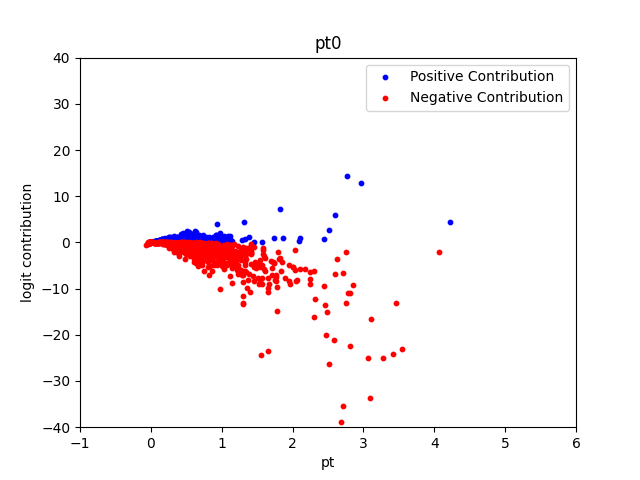

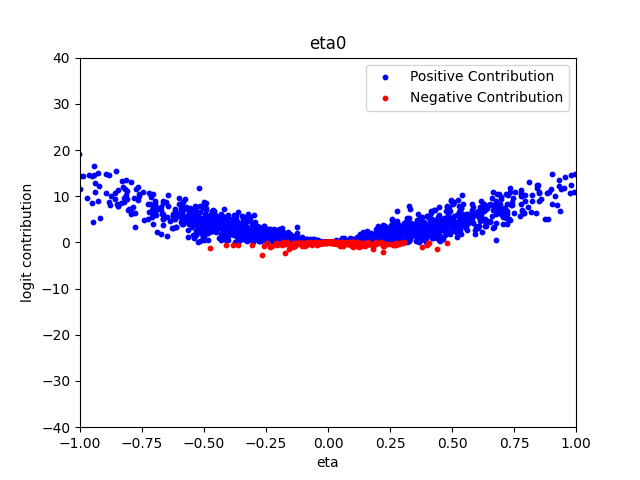

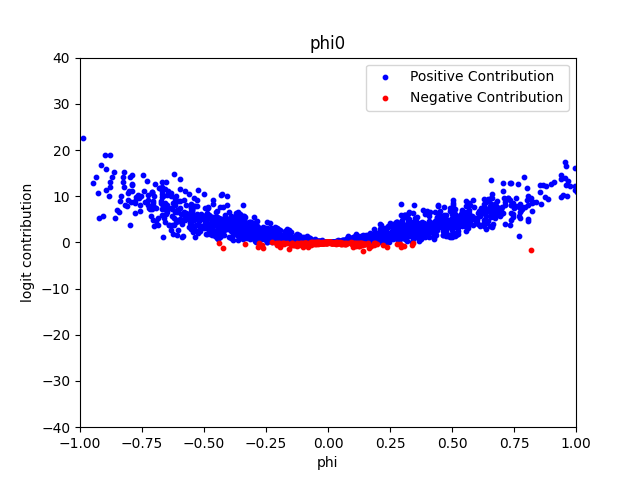

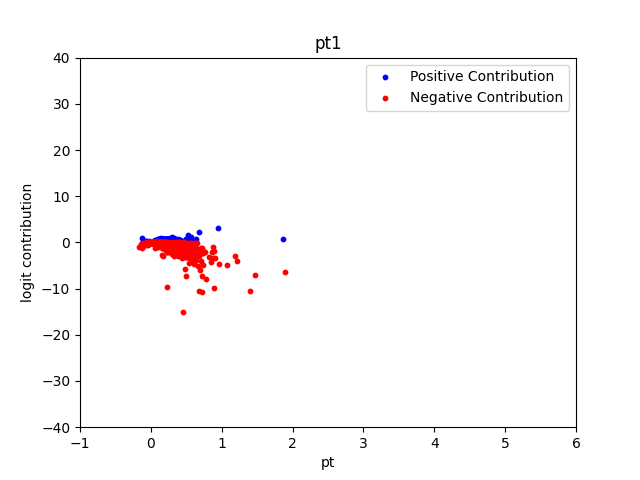

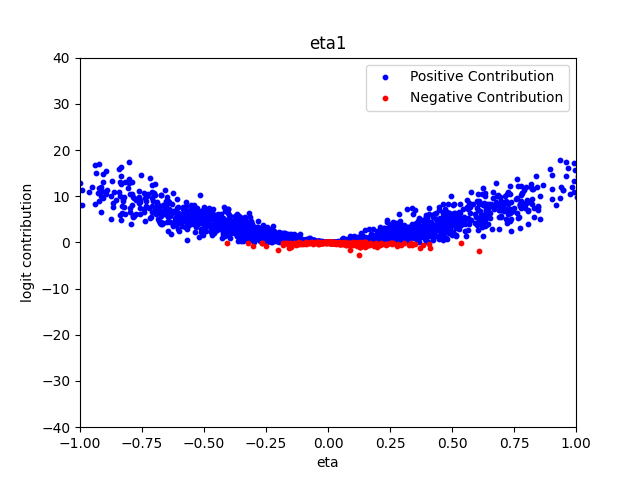

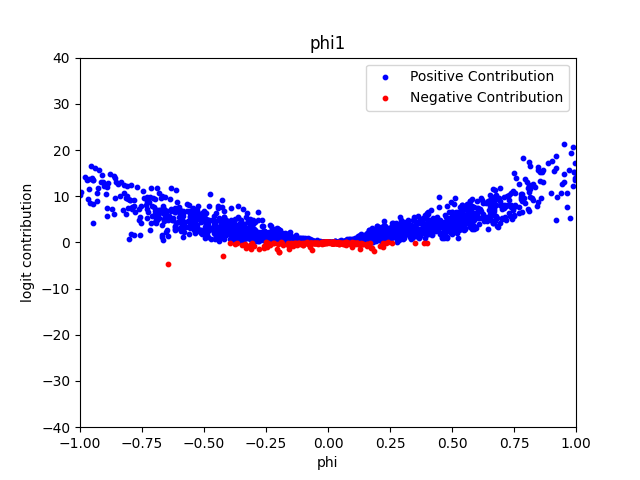

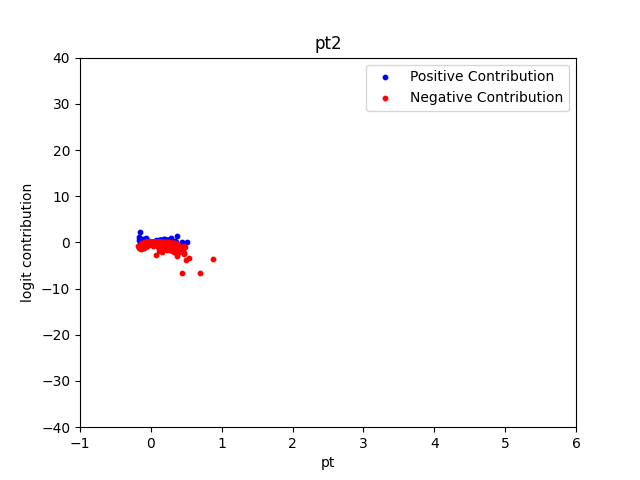

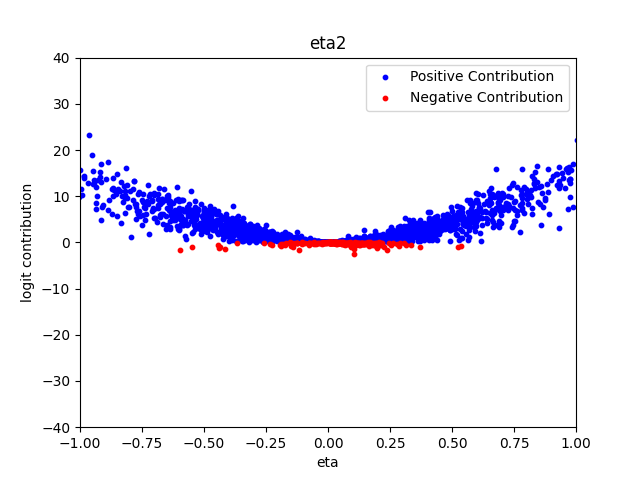

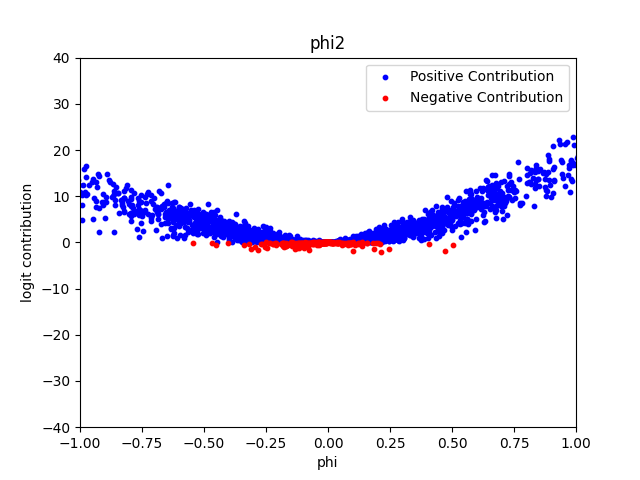

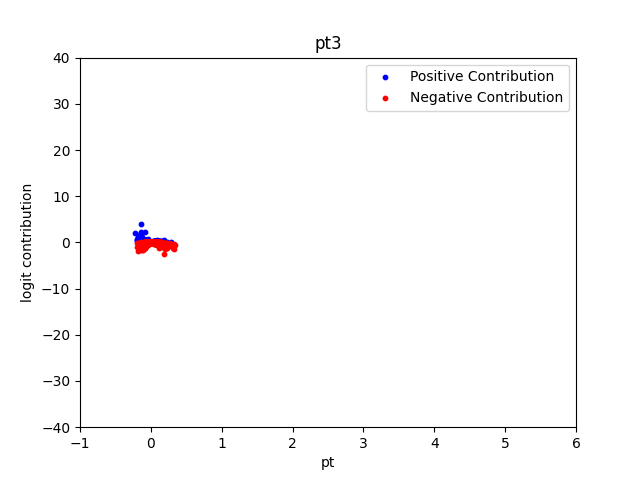

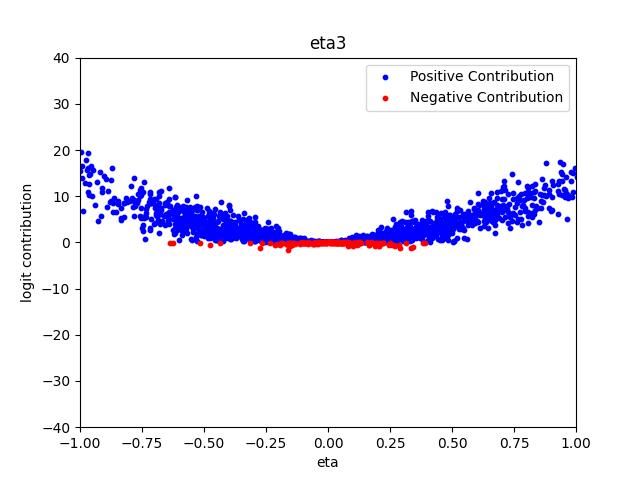

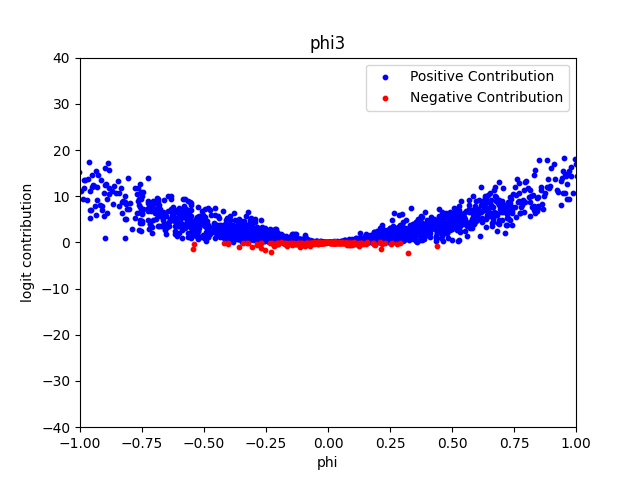

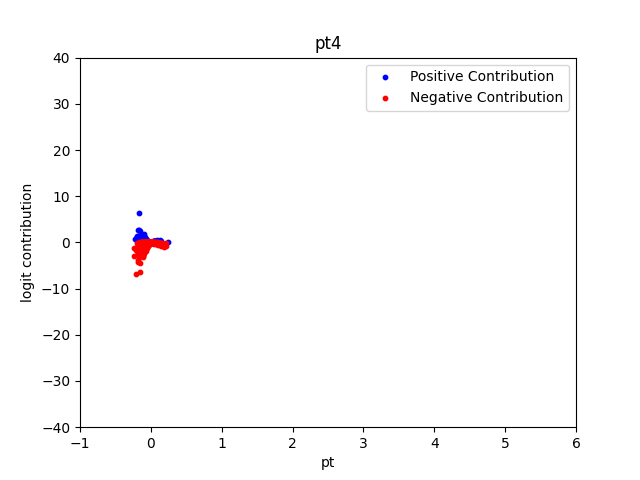

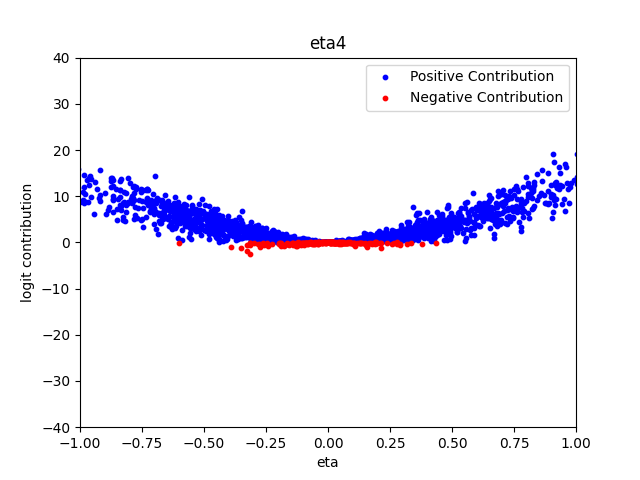

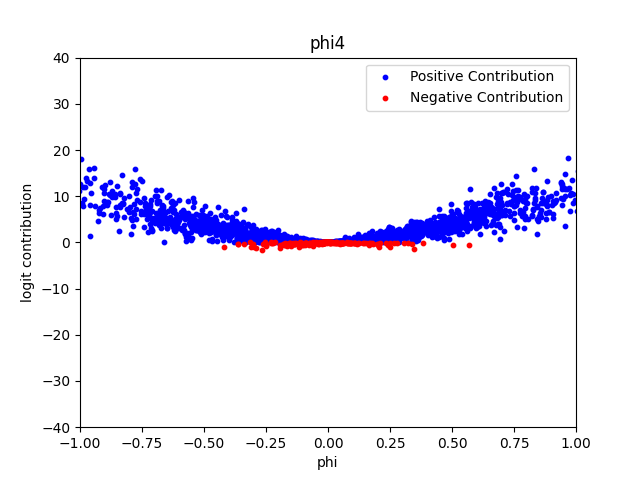

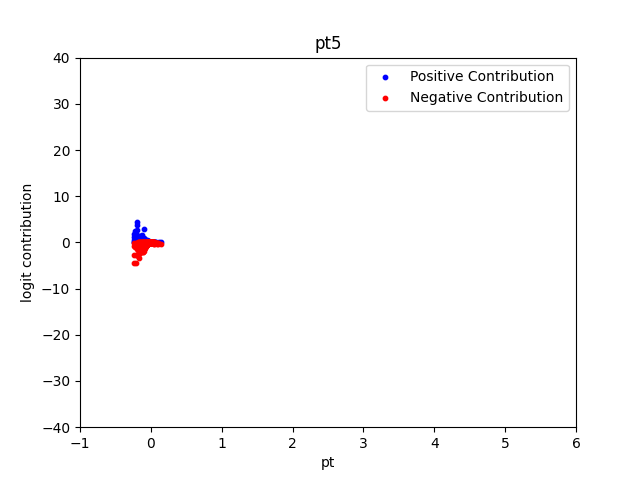

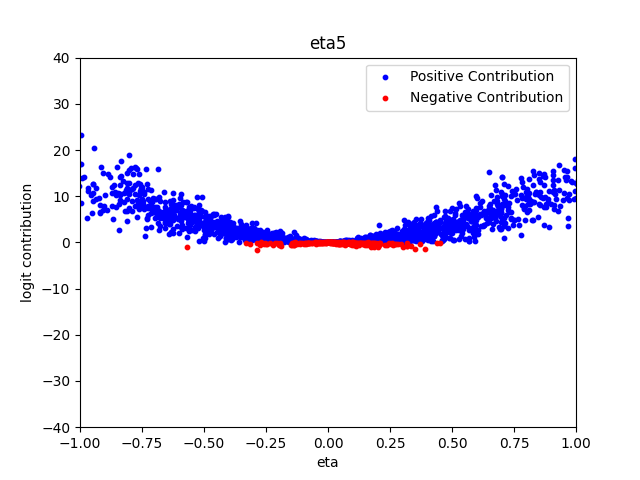

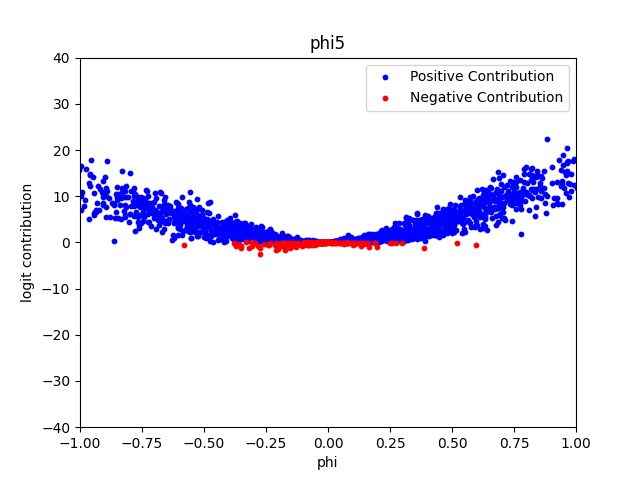

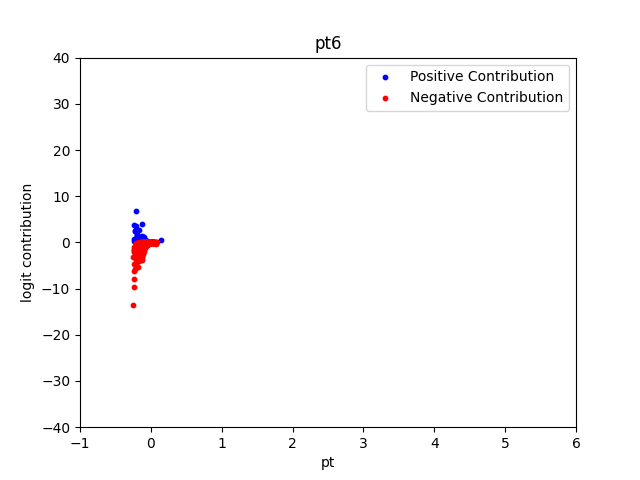

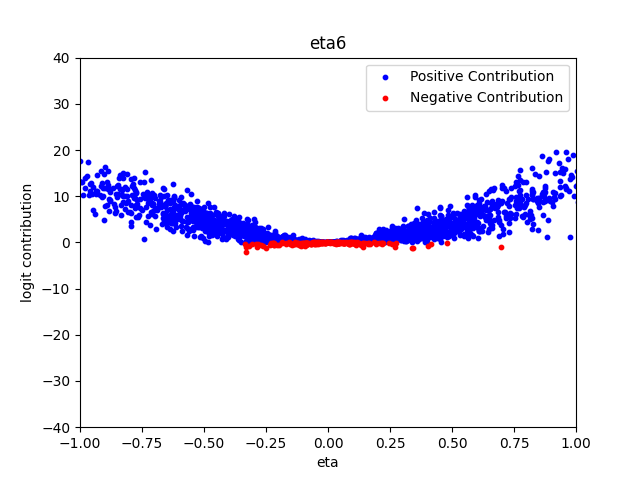

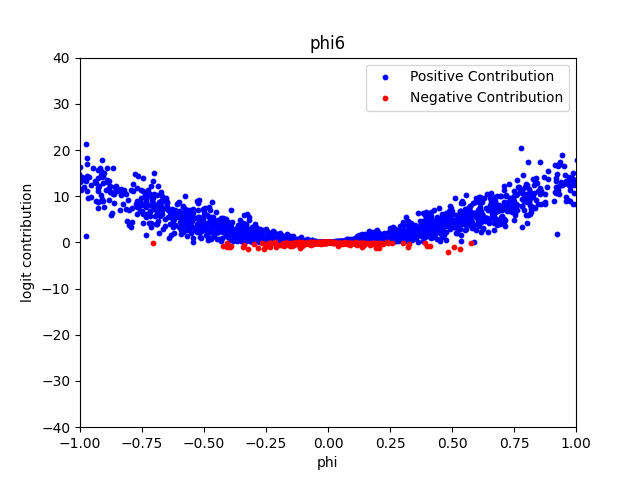

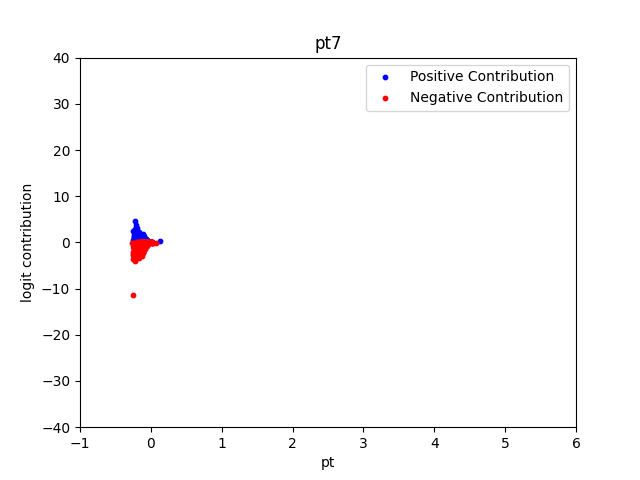

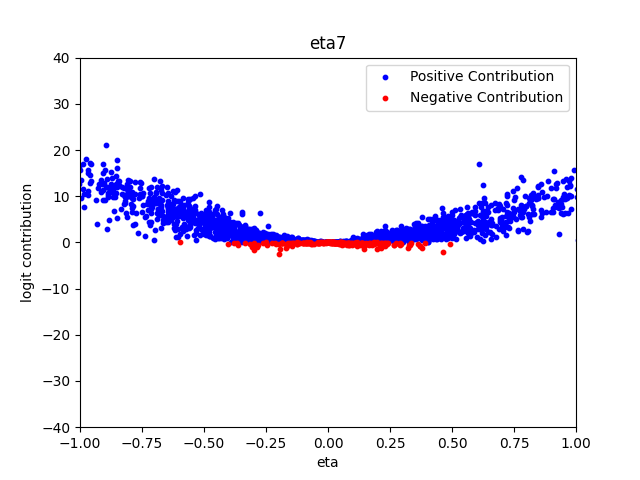

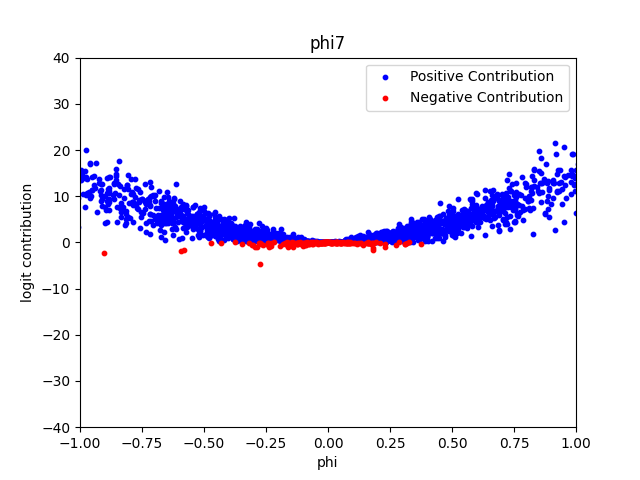

In [284]:
import matplotlib.pyplot as plt
import numpy as np


data = np.array(supWeights)[indexes][:, classJet]  

for feature in range(24):
    plt.figure()  
    
    x = np.array(jetValues)[indexes][:, feature]
    y = data[:, feature]
    
    product = x * y
    
    pos_mask = product > 0
    neg_mask = product < 0
    
    plt.scatter(x[pos_mask], product[pos_mask], s=10, c = 'blue', label='Positive Contribution')
    plt.scatter(x[neg_mask], product[neg_mask], s=10, c = 'red' ,label='Negative Contribution')
    
    plt.title(f"{feature_names[feature]}")
    if 'pt' in feature_names[feature]:
        plt.xlim(-1, 6)
        plt.ylim(-40, 40)
    else:
        plt.xlim(-1, 1)
        plt.ylim(-40, 40)
    
    plt.xlabel(feature_names[feature][:-1])
    plt.ylabel('logit contribution')
    plt.legend()
    plt.show()  


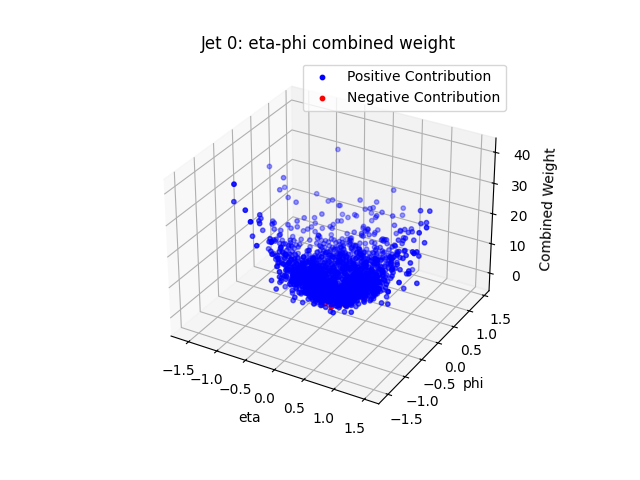

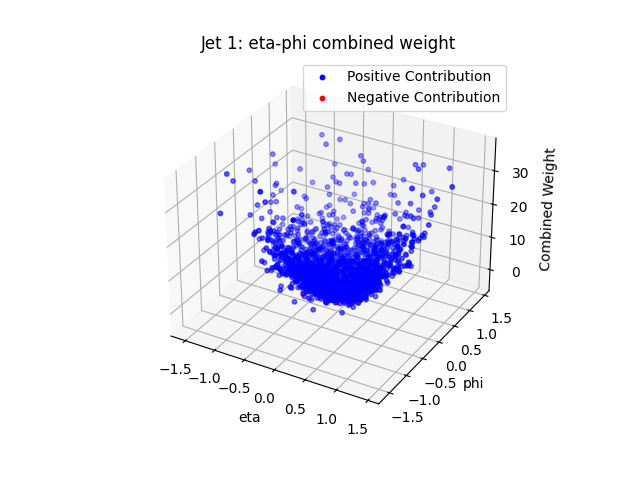

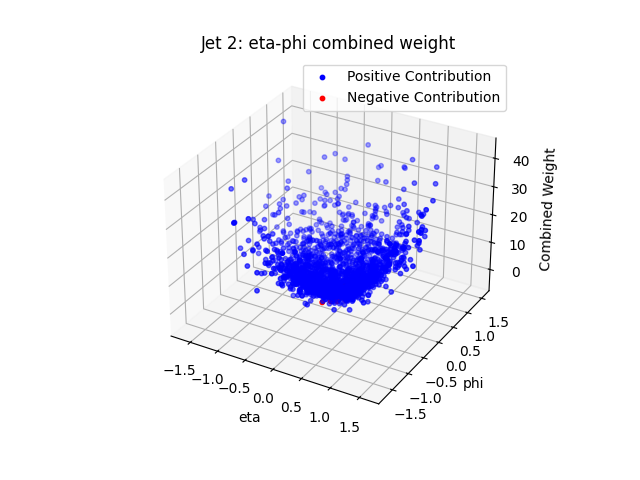

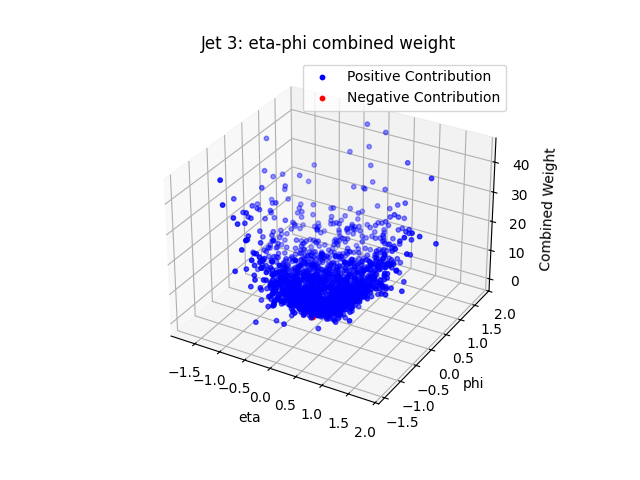

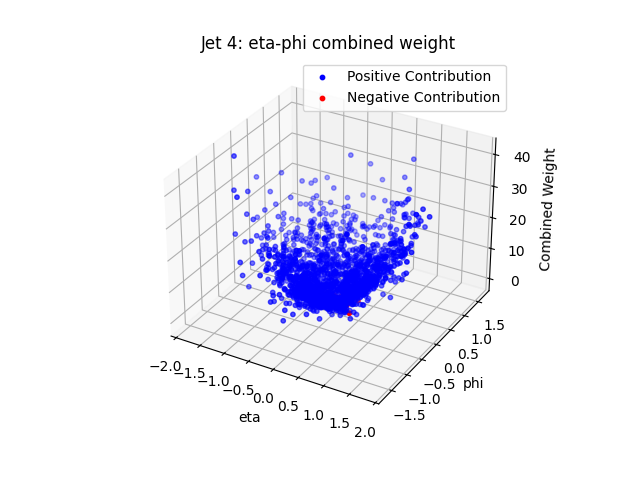

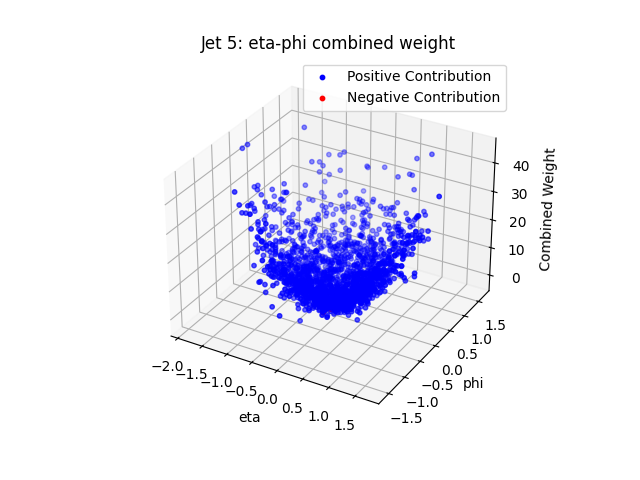

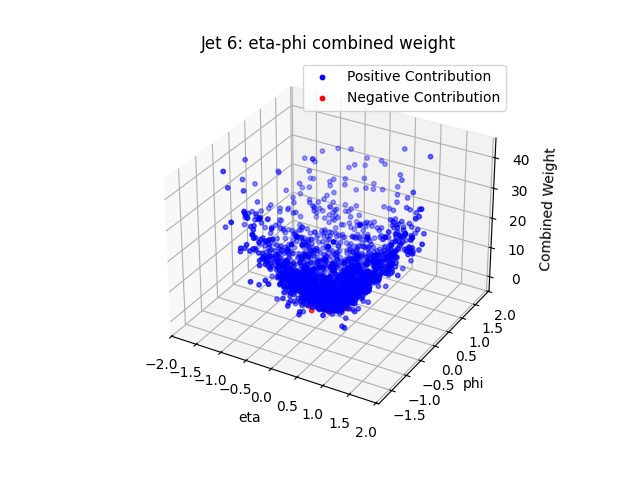

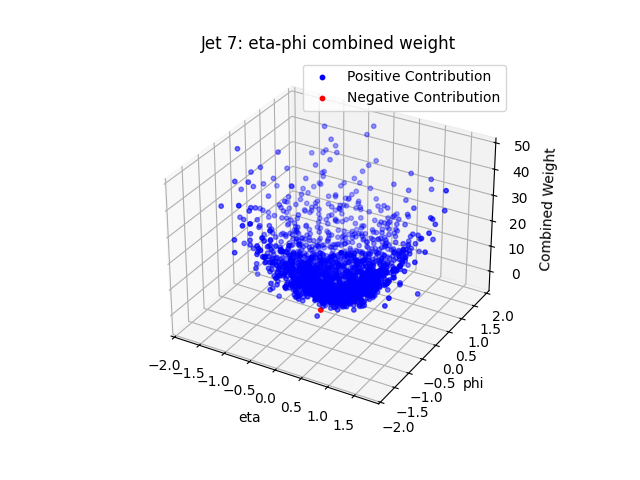

In [124]:

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# Assuming supWeights, indexes, classJet, jetValues, and feature_names are already defined.
data = np.array(supWeights)[indexes][:, classJet]

# Calculate the number of jets (each jet has three features: pt, eta, phi)
num_jets = len(feature_names) // 3

for jet in range(num_jets):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Get the eta and phi indices for the current jet
    eta_index = 3 * jet + 1
    phi_index = 3 * jet + 2
    
    # Extract eta and phi values from jetValues and corresponding weights from data
    eta_values = np.array(jetValues)[indexes][:, eta_index]
    phi_values = np.array(jetValues)[indexes][:, phi_index]
    eta_weights = data[:, eta_index]
    phi_weights = data[:, phi_index]
    
    # Compute the contribution (product of value and weight) for eta and phi
    product_eta = eta_values * eta_weights
    product_phi = phi_values * phi_weights
    
    # Combined contribution: sum of the eta and phi contributions
    combined_product = product_eta + product_phi
    
    # Define masks for positive and negative combined contributions
    pos_mask = combined_product > 0
    neg_mask = combined_product < 0
    
    # 3D scatter plot:
    # Blue for positive contributions and red for negative
    ax.scatter(eta_values[pos_mask], phi_values[pos_mask], combined_product[pos_mask],
               s=10, c='blue', label='Positive Contribution')
    ax.scatter(eta_values[neg_mask], phi_values[neg_mask], combined_product[neg_mask],
               s=10, c='red', label='Negative Contribution')
    
    ax.set_title(f"Jet {jet}: eta-phi combined weight")
    ax.set_xlabel("eta")
    ax.set_ylabel("phi")
    ax.set_zlabel("Combined Weight")
    ax.legend()
    plt.show()


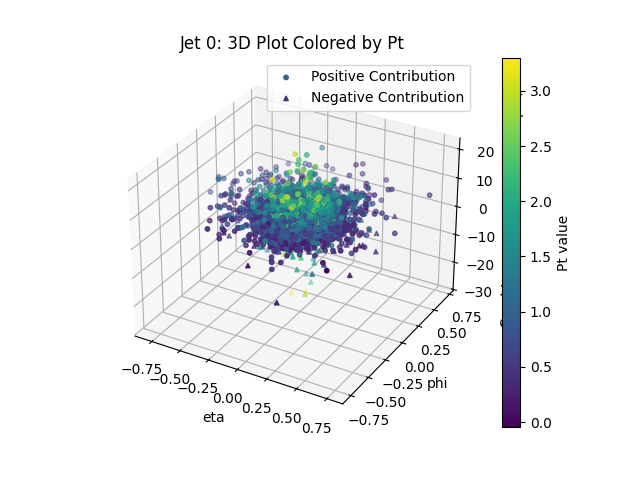

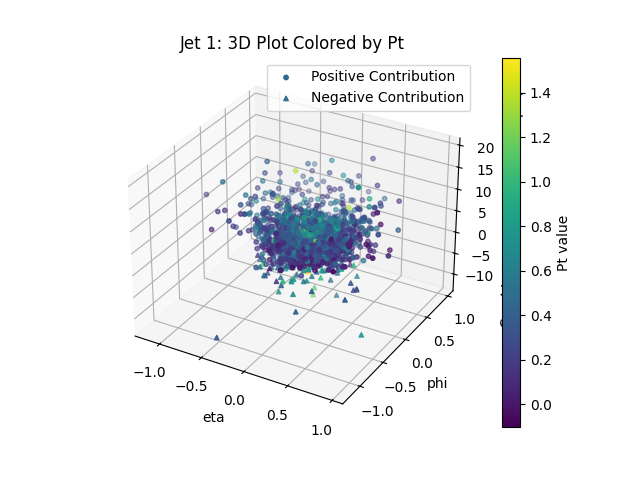

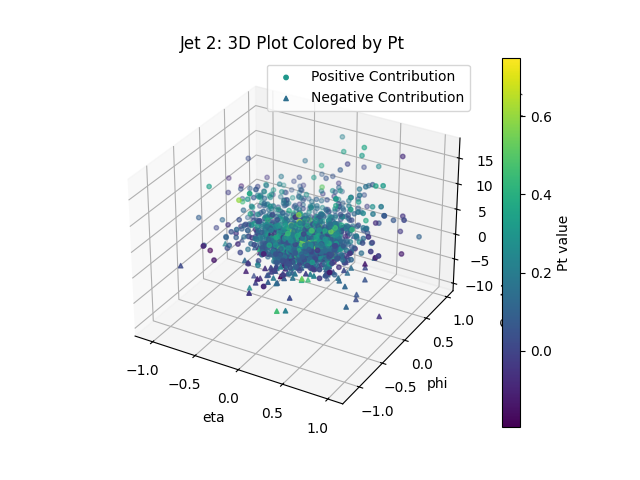

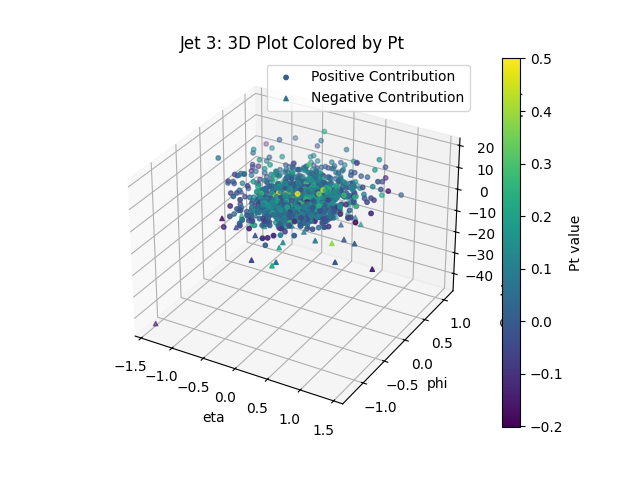

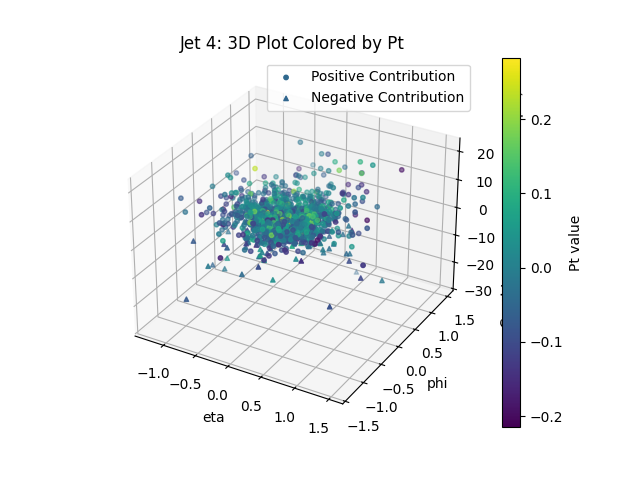

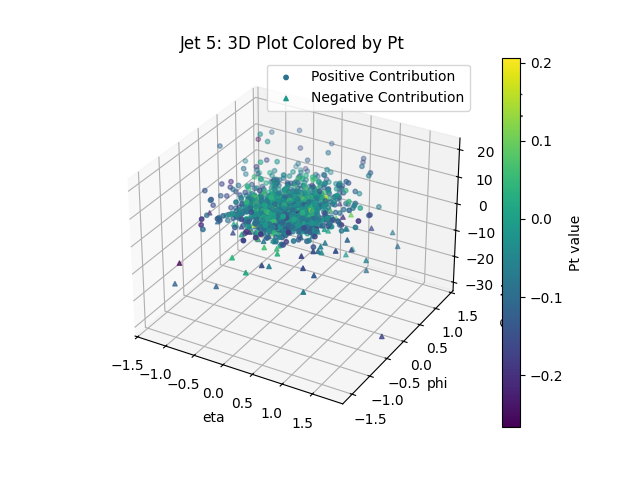

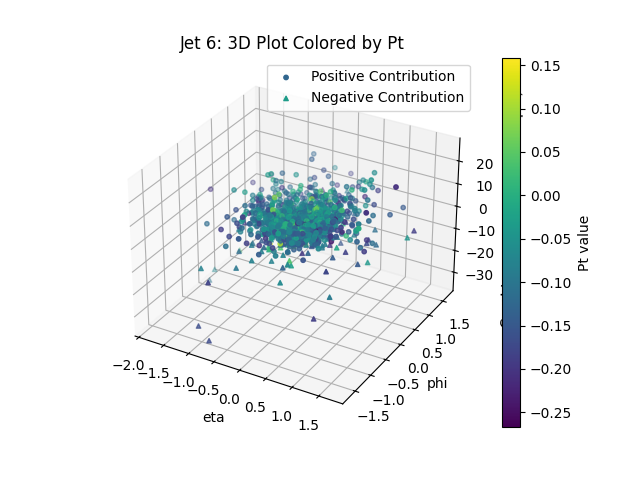

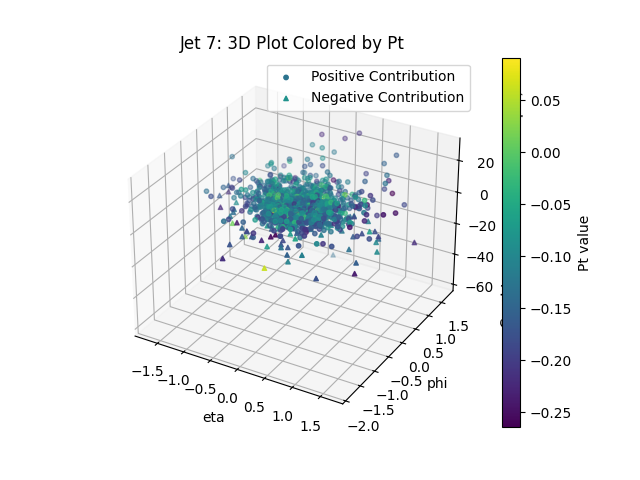

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

# Assuming supWeights, indexes, classJet, jetValues, and feature_names are already defined.
data = np.array(supWeights)[indexes][:, classJet]

# Calculate the number of jets (each jet has three features: pt, eta, phi)
num_jets = len(feature_names) // 3

for jet in range(num_jets):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Indices for pt, eta, phi for the current jet
    pt_index = 3 * jet       # pt
    eta_index = 3 * jet + 1  # eta
    phi_index = 3 * jet + 2  # phi
    
    # Extract values for pt, eta, phi from jetValues and corresponding weights from data
    jet_vals = np.array(jetValues)[indexes]
    pt_values = jet_vals[:, pt_index]
    eta_values = jet_vals[:, eta_index]
    phi_values = jet_vals[:, phi_index]
    
    pt_weights = data[:, pt_index]
    eta_weights = data[:, eta_index]
    phi_weights = data[:, phi_index]
    
    # Compute the weighted contributions
    product_pt = pt_values * pt_weights
    product_eta = eta_values * eta_weights
    product_phi = phi_values * phi_weights
    
    # Combined contribution: include pt contribution along with eta and phi
    combined_product = product_pt + product_eta + product_phi
    
    # Define masks based on the sign of the combined contribution
    pos_mask = combined_product > 0
    neg_mask = combined_product < 0
    
    # 3D scatter plot: use pt_values for coloring.
    # Positive contributions are circles and negative contributions are triangles.
    scatter_pos = ax.scatter(eta_values[pos_mask],
                             phi_values[pos_mask],
                             combined_product[pos_mask],
                             s=10, 
                             c=pt_values[pos_mask], 
                             marker='o', 
                             cmap='viridis', 
                             label='Positive Contribution')
    
    scatter_neg = ax.scatter(eta_values[neg_mask],
                             phi_values[neg_mask],
                             combined_product[neg_mask],
                             s=10, 
                             c=pt_values[neg_mask], 
                             marker='^',  # triangles for negative contributions
                             cmap='viridis', 
                             label='Negative Contribution')
    
    ax.set_title(f"Jet {jet}: 3D Plot Colored by Pt")
    ax.set_xlabel("eta")
    ax.set_ylabel("phi")
    ax.set_zlabel("Combined Weight (pt + eta + phi)")
    ax.legend()
    
    # Add a colorbar to show the pt value scale.
    fig.colorbar(scatter_pos, ax=ax, label="Pt value")
    plt.show()


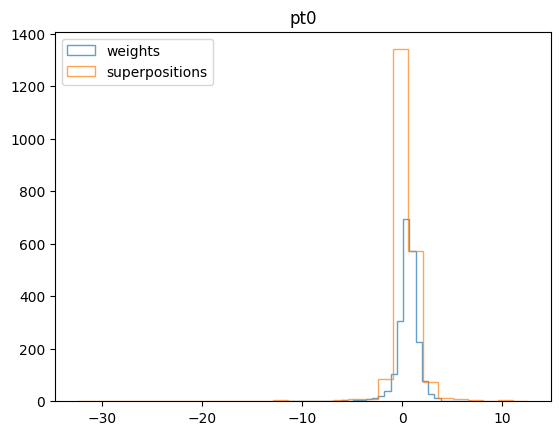

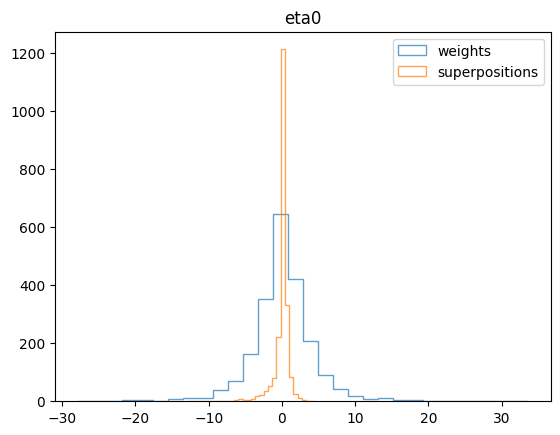

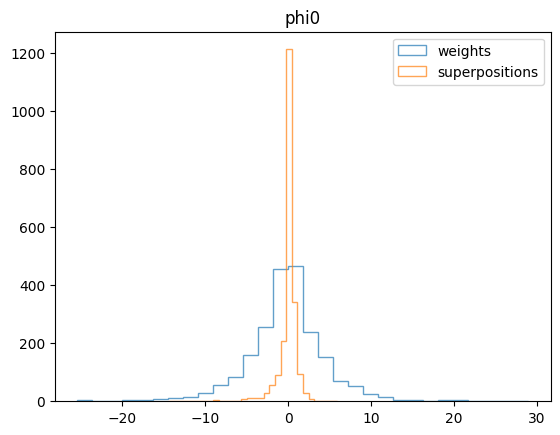

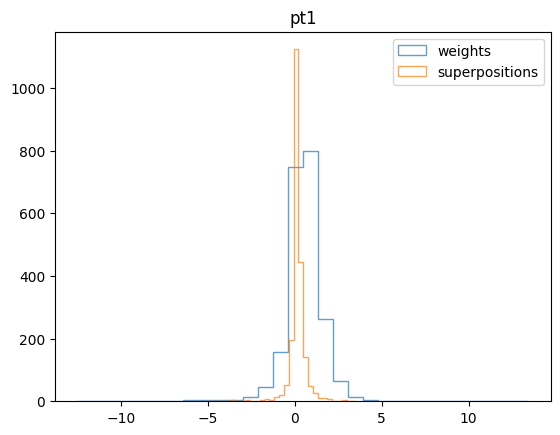

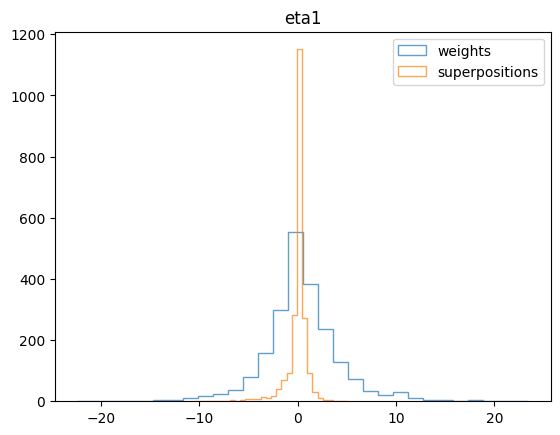

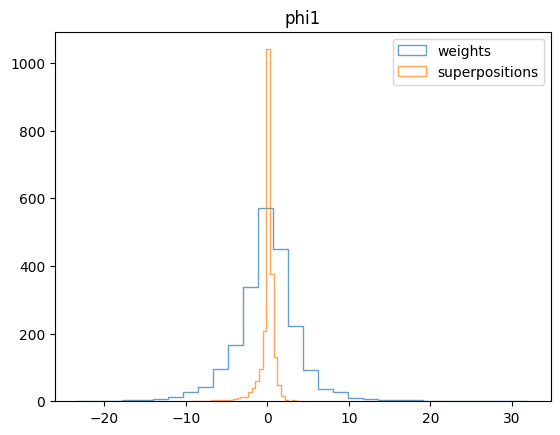

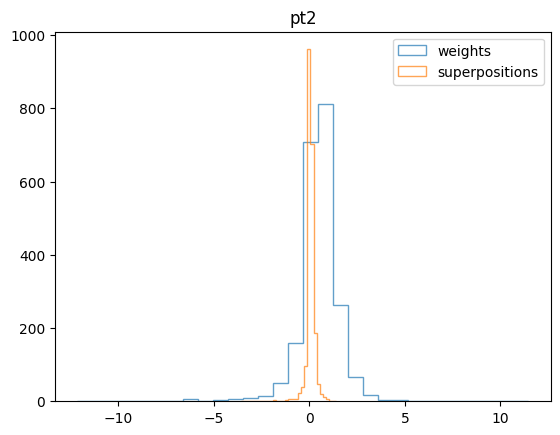

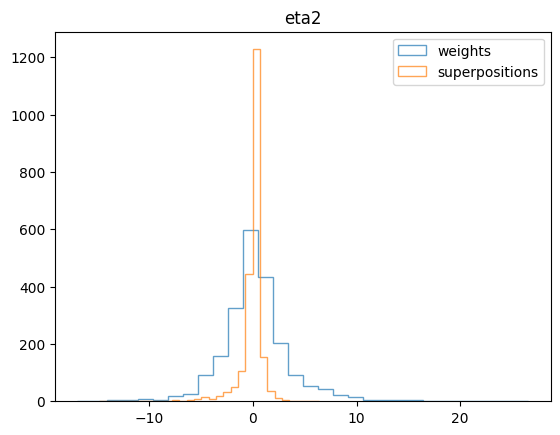

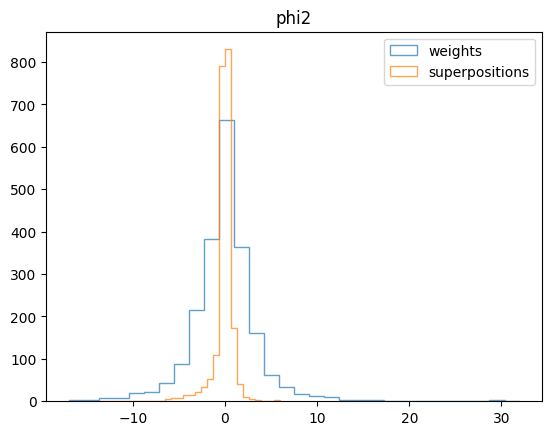

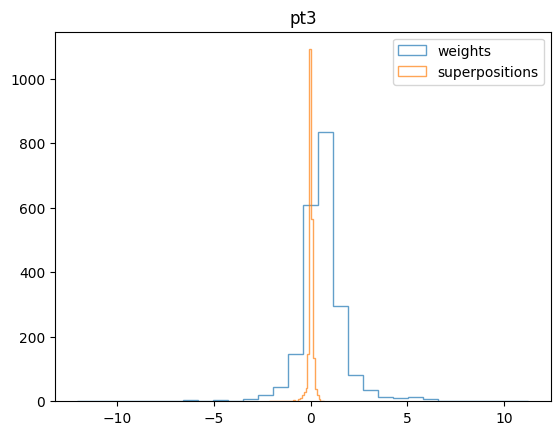

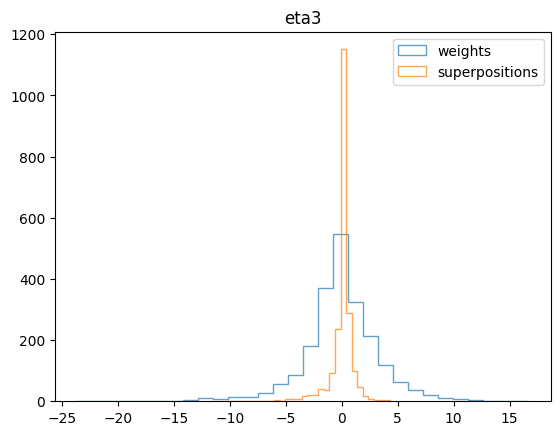

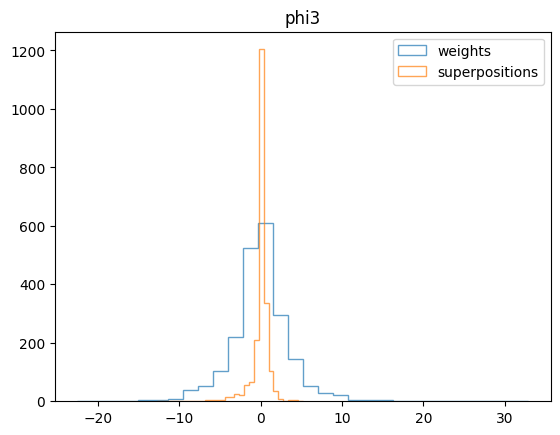

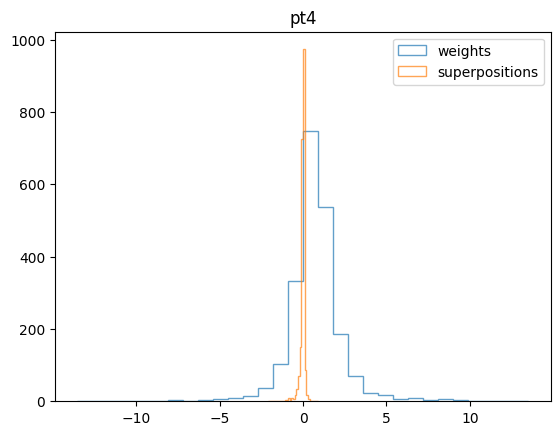

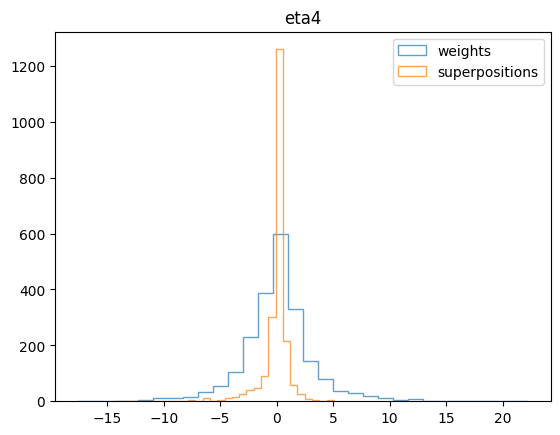

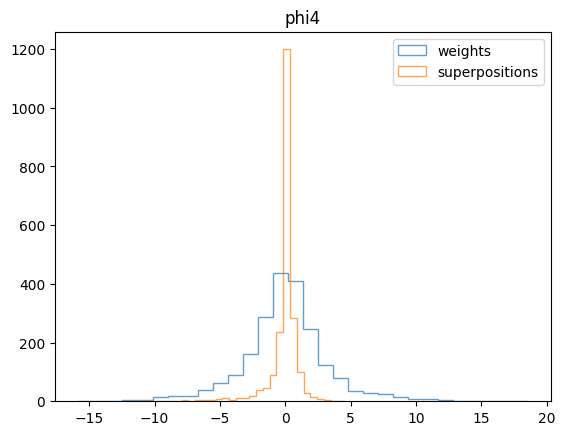

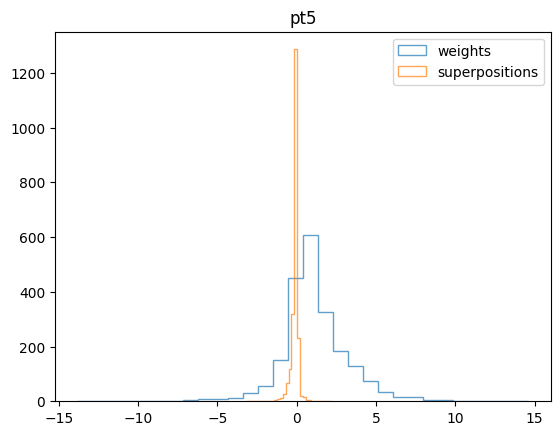

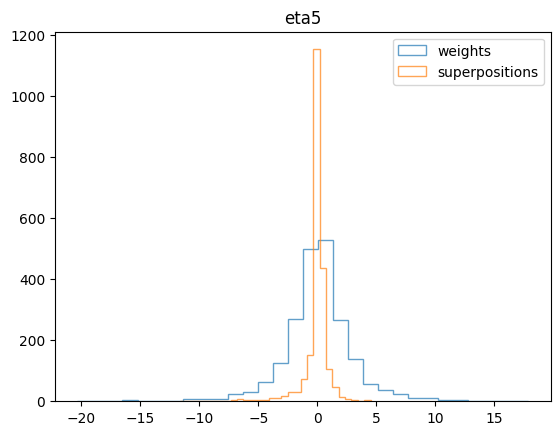

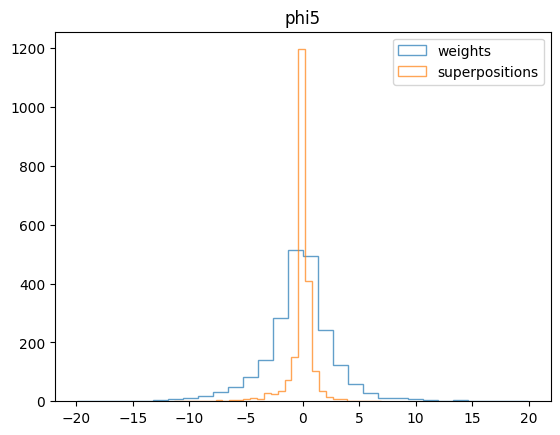

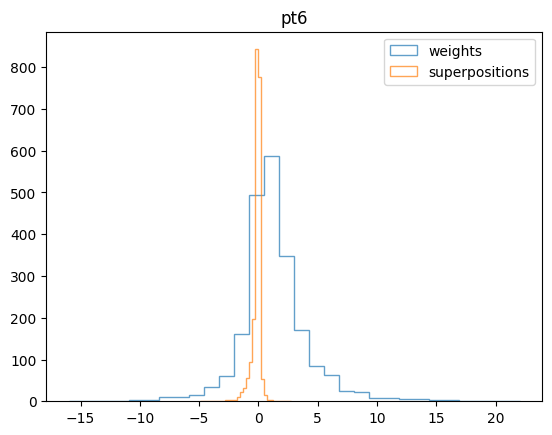

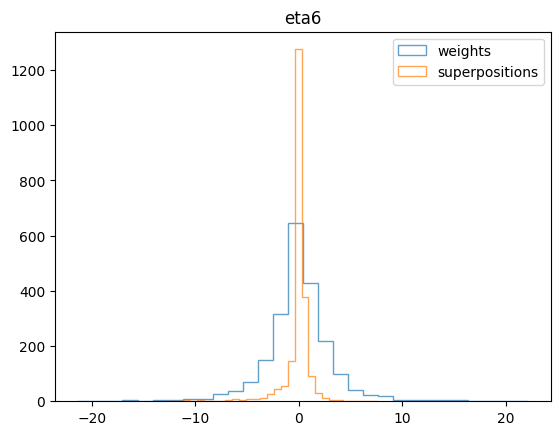

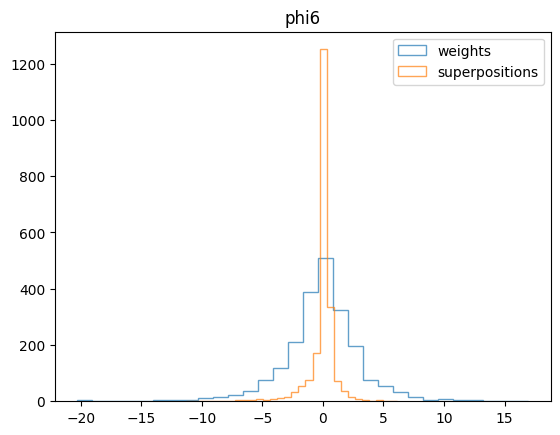

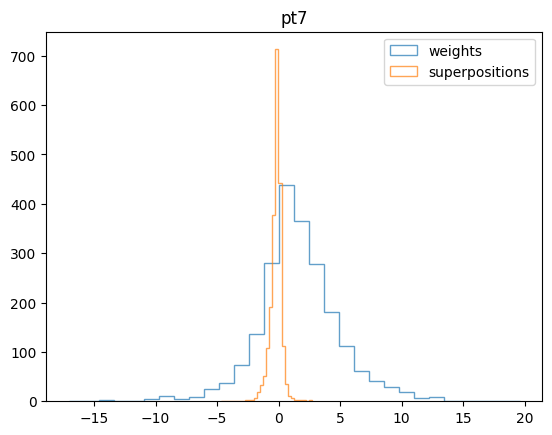

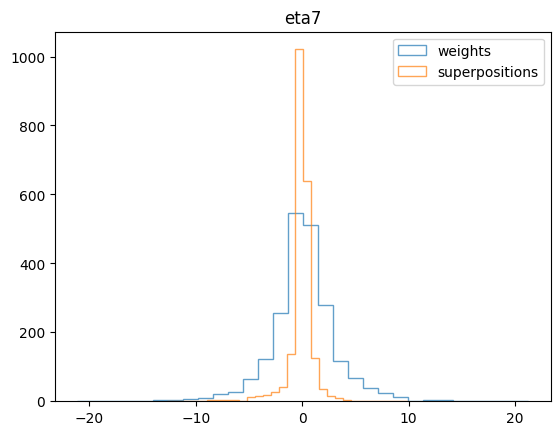

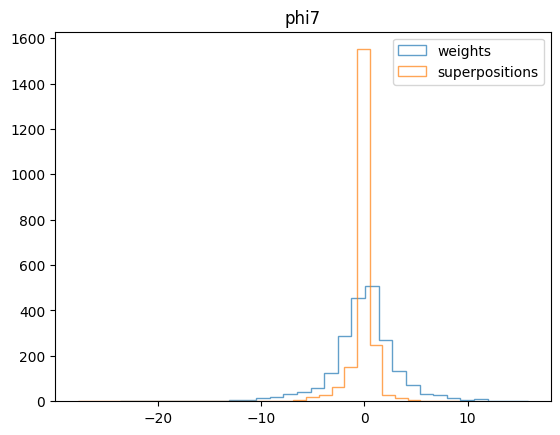

In [661]:
for feature in range(24):
    plt.figure()
    plt.hist(np.array(supWeights)[indexes][:, classJet, feature], label='weights', alpha=0.7,histtype='step', bins=30)
    plt.hist(np.array(superpositions)[indexes][:, classJet, feature], label='superpositions', alpha=0.7, histtype='step', bins=30)
    #plt.hist(np.array(jetValues[:,feature]), label = str(feature_names[feature]), bins=30)
    plt.legend()
    #plt.yscale('log')
    plt.title(str(feature_names[feature]))
    plt.show()


In [368]:
jetValues.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
np.array(superpositions)[indexes][:, classJet, feature].shape

(2081,)

In [ ]:
(jetValues[:,feature]/np.array(superpositions)[indexes][:, classJet, feature]).shape


(2081,)

In [ ]:
np.sum(np.array(superpositions)[indexes][:, classJet], axis=1).shape

(2081,)

In [ ]:
np.array(superpositions)[indexes].shape

(2104, 5, 25)

In [ ]:
x_val.reshape(260000,24)[0]

array([ 0.27815351,  0.21223249,  0.1754753 ,  0.09936476,  0.18245495,
        0.16967006, -0.05107   ,  0.22790572,  0.11086851, -0.05791533,
        0.11480459,  0.22412738, -0.07637478,  0.16351815,  0.12682554,
       -0.10286177, -1.46739231, -0.34534964, -0.13006857,  1.0365486 ,
       -0.33158629, -0.13600302,  0.29777362,  0.13872294])

In [ ]:
np.array(logits)[indexes]

array([ 0.81782187,  0.51263792, -0.43747133, -0.82541861, -3.20790842])

In [369]:
np.mean(accuracyModel)

0.9147

In [370]:
np.mean(accuracyTrue)

0.6312

(array([193.,   0., 193.,   0.,   0., 217.,   0., 213.,   0., 184.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

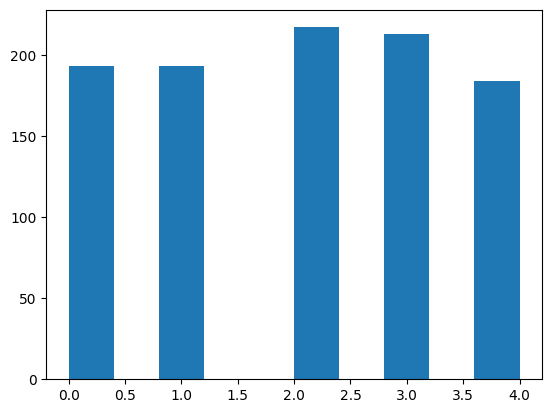

In [42]:
plt.hist(np.argmax(logits,1))

In [36]:
# Initialize superposition matrix with diagonal values

superposition = np.zeros((24, 25))
num = 0
for x in x_val[0].flatten():
    superposition[num, num] = x
    num = num + 1

# Process through each layer
supList = []
for layer_idx in range(0, len(loaded_model.variables), 2):
    weight = loaded_model.variables[layer_idx].numpy()
    bias = loaded_model.variables[layer_idx+1].numpy()
    
    # Apply the MLP
    superposition = superpositionMLP(superposition, weight, bias)
    
    # Apply ReLU (except for the output layer)
    if layer_idx != 16:  # Assuming layer 8 is your output layer
        superposition = superPositionRelu(superposition)
    
    supList.append(superposition.copy())

# Extract logits from final superposition
logitSup = []
for neuron_superposition in superposition:
    logitSup.append(np.sum(neuron_superposition))



In [763]:
for decay in range(5):  
    print(array_to_dict(np.divide(supList[8][decay][0:24], x_val[0].flatten())))

{'pt0': -2.858612671521276, 'eta0': 2.7597402148267536, 'phi0': 3.418059453669607, 'pt1': -3.9261017290519336, 'eta1': 2.6223569224368126, 'phi1': 3.721490653781707, 'pt2': -2.19187291190239, 'eta2': 0.4691194534387501, 'phi2': 3.515184222720092, 'pt3': -7.4123138405313265, 'eta3': 0.3883995599149506, 'phi3': 0.9205041612664551, 'pt4': -3.4720428785675566, 'eta4': -0.14585649489617555, 'phi4': 0.7683216447461794, 'pt5': -3.694630116782345, 'eta5': -2.99282959782712, 'phi5': 1.4933250709079258, 'pt6': -12.62914801787099, 'eta6': 1.083964754382976, 'phi6': 1.881892450672798, 'pt7': -8.412499248089018, 'eta7': 0.47955087783262745, 'phi7': 1.3498714953376039}
{'pt0': -0.40934512456571015, 'eta0': 2.333519071276505, 'phi0': 3.2682568041202353, 'pt1': -1.6539034876692156, 'eta1': 2.3259868930367134, 'phi1': 3.712086957860425, 'pt2': -0.5456000665313733, 'eta2': 0.0505615151364222, 'phi2': 2.818381388709445, 'pt3': -2.3600323704983595, 'eta3': 0.7568399099594771, 'phi3': 1.0359783013750596, '

In [784]:
supList[8][0][0:24]

array([-0.79513315,  0.58570652,  0.59978501, -0.39011615,  0.47846198,
        0.63142554,  0.11193895,  0.10691501,  0.38972322,  0.4292866 ,
        0.04459005,  0.20631019,  0.2651765 , -0.02385018,  0.09744281,
        0.38003619,  4.39165518, -0.51571928,  1.64265523,  1.12358216,
       -0.6240097 ,  1.14412528,  0.14279761,  0.18725814])

In [ ]:
array_to_dict(np.divide(supList[8][0][0:24], x_val[1].flatten()))

{'pt0': -0.35363714564634124,
 'eta0': -17.760638570673134,
 'phi0': 12.147075387625218,
 'pt1': -0.10839393983801447,
 'eta1': -18.368167352152035,
 'phi1': 14.211802641194133,
 'pt2': 4.1177151889623795,
 'eta2': 55.41283915030115,
 'phi2': 13.694203217787798,
 'pt3': 24.523629041461827,
 'eta3': -11.590457615556172,
 'phi3': 7.408472488802698,
 'pt4': 46.56275772078794,
 'eta4': -7.7138181689063785,
 'phi4': 5.767503740250137,
 'pt5': -13.323482564574773,
 'eta5': -117.63601527613483,
 'phi5': -1.8870907940391626,
 'pt6': -19.766474507626956,
 'eta6': -22.73635300012871,
 'phi6': -3.090163151058177,
 'pt7': -12.514831946322415,
 'eta7': 3.8385015435574577,
 'phi7': -6.887797176395076}

In [779]:
array_to_dict(np.divide(supList[8][0][0:24], x_val[1].flatten()))

{'pt0': -0.10099174696654152,
 'eta0': 0.3151419560022542,
 'phi0': -2.7631610178010253,
 'pt1': 0.12044997691601438,
 'eta1': -0.10265769699183457,
 'phi1': -1.4781070593414416,
 'pt2': 0.06280263727610126,
 'eta2': 0.27562868018536085,
 'phi2': -1.933351271422149,
 'pt3': 0.061102055974394956,
 'eta3': 0.8567513782418938,
 'phi3': -1.4588266975494655,
 'pt4': 0.10707880004648002,
 'eta4': 0.16333457045488584,
 'phi4': -1.4503228423236052,
 'pt5': 0.3087711464752902,
 'eta5': -0.1762894442251704,
 'phi5': -1.1116334666101406,
 'pt6': -0.24156572259296033,
 'eta6': 0.3790916502960445,
 'phi6': -1.8448113842241318,
 'pt7': 3.109229522614922,
 'eta7': 1.201947778631635,
 'phi7': -3.1146456130133817}

In [105]:
supList[9]

IndexError: list index out of range

In [56]:
prob = softmax(logits, axis = 1)

In [53]:
target = y_val[0:1000]

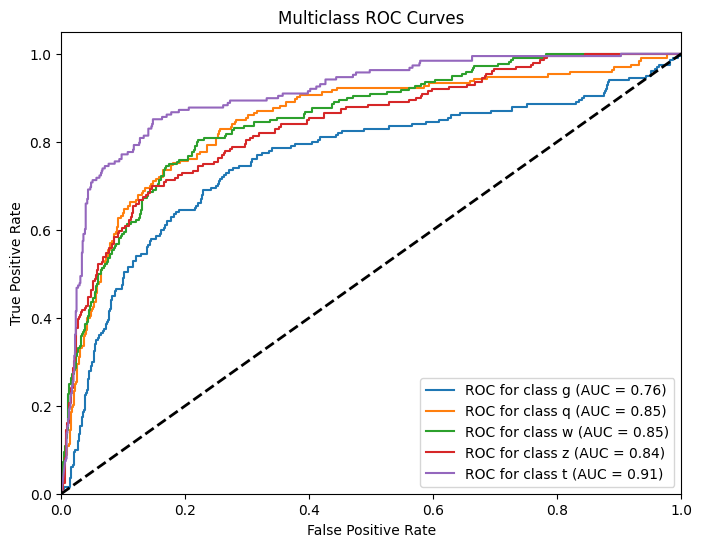

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Your class labels
classes = ['g', 'q', 'w', 'z', 't']

# Dictionaries to store FPR, TPR, and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve and ROC area for each class
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(target[:, i], prob[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Plotting the ROC curves for each class
plt.figure(figsize=(8, 6))
for cls in classes:
    plt.plot(fpr[cls], tpr[cls],
             label=f'ROC for class {cls} (AUC = {roc_auc[cls]:0.2f})')

# Plotting the diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.show()


In [765]:
array_to_dict(np.divide(supList[8][1][0:24], x_val[0].flatten()))

{'pt0': -0.40934512456571015,
 'eta0': 2.333519071276505,
 'phi0': 3.2682568041202353,
 'pt1': -1.6539034876692156,
 'eta1': 2.3259868930367134,
 'phi1': 3.712086957860425,
 'pt2': -0.5456000665313733,
 'eta2': 0.0505615151364222,
 'phi2': 2.818381388709445,
 'pt3': -2.3600323704983595,
 'eta3': 0.7568399099594771,
 'phi3': 1.0359783013750596,
 'pt4': 0.3762724494335207,
 'eta4': 0.4001687482781339,
 'phi4': 0.18616300564989613,
 'pt5': -0.452080798641947,
 'eta5': -1.8999961605832354,
 'phi5': 1.8265659545188593,
 'pt6': -4.986701275251183,
 'eta6': -0.8631404592901474,
 'phi6': 2.1570654316473266,
 'pt7': 0.212007812644146,
 'eta7': -1.1162801945782017,
 'phi7': 0.4514698363288063}

In [ ]:
supList*x_val